<a href="https://colab.research.google.com/github/nishith1001/CSE455_FINAL_PROJECT/blob/main/CSE455_FINAL_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CSE 455 FINAL PROJECT - KAGGLE BIRD CLASSIFICATION

Nishith Palakodeti

I decided to use different neural network models that could recognize different species of Birds. The predictions of these models were then entered into the kaggle competition to rate the accuracy.

For my neural nets, I used 1 pretrained resnet model from torch, a DarkNet model that is defined below, and another resnet model from facebook. I then see how the three compare in terms of accuracy for this specific problem. Below are the steps that I take to train and test the models.

We would first need to install the kaggle library to be able to use their dataset.

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

We then need to make sure to download the kaggle.json file from the competetion's website and upload it here, placing it into the right directory to make sure we have the right permissions to be able to download the data from kaggle.

In [ ]:
from google.colab import files

files.upload()
  
# Move kaggle.json into the folder where the API expects to find it and update required permissions
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

The following blocks of code download and unzip the data and make any necessary imports in order to run and visualize the performance of the models.

In [ ]:
!kaggle competitions download -c birds22sp

In [ ]:
!unzip birds22sp.zip -d birds22sp

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Below we change the dataset into a format that can be used for training. Using code taken from the Pytorch Tutorials in class and modifying to suit the needs of the data provided by kaggle, I made sure to define the correct paths for the files and made sure to define the correct classes mapping them to indices. One issue that arised was that the images were not all the same size so I had to make sure to resize and add random cropping to be able to train with the images.

In [7]:
def get_bird_data(augmentation=0):
    transform_train = transforms.Compose([
        transforms.Resize(128),
        transforms.RandomCrop(128, padding=8, padding_mode='edge'), # Take 128x128 crops from padded images
        transforms.RandomHorizontalFlip(),    # 50% of time flip image along y-axis
        transforms.ToTensor(),
    ])
    
    transform_test = transforms.Compose([
        transforms.Resize(128),
        transforms.ToTensor(),
    ])
    trainset = torchvision.datasets.ImageFolder(root='/content/birds22sp/birds/train', transform=transform_train)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

    testset = torchvision.datasets.ImageFolder(root='/content/birds22sp/birds/test', transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)
    classes = open("/content/birds22sp/birds/names.txt").read().strip().split("\n")
    class_to_idx = trainset.class_to_idx
    idx_to_class = {int(v): int(k) for k, v in class_to_idx.items()}
    idx_to_name = {k: classes[v] for k,v in idx_to_class.items()}
    return {'train': trainloader, 'test': testloader, 'to_class': idx_to_class, 'to_name':idx_to_name}

data = get_bird_data()

The following blocks of code try to visualize the data and showcase some statsictics about its size. As you can see, there are 555 different species of birds.

In [8]:
print(len(data['to_name']))

555


In [9]:
print(data['to_class'])
print(data['to_name'])

{0: 0, 1: 1, 2: 10, 3: 100, 4: 101, 5: 102, 6: 103, 7: 104, 8: 105, 9: 106, 10: 107, 11: 108, 12: 109, 13: 11, 14: 110, 15: 111, 16: 112, 17: 113, 18: 114, 19: 115, 20: 116, 21: 117, 22: 118, 23: 119, 24: 12, 25: 120, 26: 121, 27: 122, 28: 123, 29: 124, 30: 125, 31: 126, 32: 127, 33: 128, 34: 129, 35: 13, 36: 130, 37: 131, 38: 132, 39: 133, 40: 134, 41: 135, 42: 136, 43: 137, 44: 138, 45: 139, 46: 14, 47: 140, 48: 141, 49: 142, 50: 143, 51: 144, 52: 145, 53: 146, 54: 147, 55: 148, 56: 149, 57: 15, 58: 150, 59: 151, 60: 152, 61: 153, 62: 154, 63: 155, 64: 156, 65: 157, 66: 158, 67: 159, 68: 16, 69: 160, 70: 161, 71: 162, 72: 163, 73: 164, 74: 165, 75: 166, 76: 167, 77: 168, 78: 169, 79: 17, 80: 170, 81: 171, 82: 172, 83: 173, 84: 174, 85: 175, 86: 176, 87: 177, 88: 178, 89: 179, 90: 18, 91: 180, 92: 181, 93: 182, 94: 183, 95: 184, 96: 185, 97: 186, 98: 187, 99: 188, 100: 189, 101: 19, 102: 190, 103: 191, 104: 192, 105: 193, 106: 194, 107: 195, 108: 196, 109: 197, 110: 198, 111: 199, 112

torch.Size([8, 3, 128, 128])


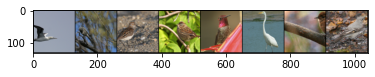

Labels:Northern Gannet (Immature/Juvenile), Phainopepla (Female/juvenile), Western Sandpiper, Lincoln's Sparrow, Anna's Hummingbird (Adult Male), Great Egret, Winter Wren, Townsend's Solitaire


In [10]:
dataiter = iter(data['train'])
images, labels = dataiter.next()
images = images[:8]
print(images.size())

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print("Labels:" + ', '.join('%9s' % data['to_name'][labels[j].item()] for j in range(8)))

The following lines of code defines the training function required to train the models. The smooth function used to plot the results of the losses during the training is also defined here.

In [11]:
def train(net, dataloader, epochs=1, start_epoch=0, lr=0.01, momentum=0.9, decay=0.0005, 
          verbose=1, print_every=10, state=None, schedule={}, checkpoint_path=None):
    net.to(device)
    net.train()
    losses = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)

    # Load previous training state
    if state:
        net.load_state_dict(state['net'])
        optimizer.load_state_dict(state['optimizer'])
        start_epoch = state['epoch']
        losses = state['losses']

    # Fast forward lr schedule through already trained epochs
    for epoch in range(start_epoch):
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

    for epoch in range(start_epoch, epochs):
        sum_loss = 0.0

        # Update learning rate when scheduled
        if epoch in schedule:
            print ("Learning rate: %f"% schedule[epoch])
            for g in optimizer.param_groups:
                g['lr'] = schedule[epoch]

        for i, batch in enumerate(dataloader, 0):
            inputs, labels = batch[0].to(device), batch[1].to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # autograd magic, computes all the partial derivatives
            optimizer.step() # takes a step in gradient direction

            losses.append(loss.item())
            sum_loss += loss.item()

            if i % print_every == print_every-1:    # print every 10 mini-batches
                if verbose:
                  print('[%d, %5d] loss: %.3f' % (epoch, i + 1, sum_loss / print_every))
                sum_loss = 0.0
        if checkpoint_path:
            state = {'epoch': epoch+1, 'net': net.state_dict(), 'optimizer': optimizer.state_dict(), 'losses': losses}
            torch.save(state, checkpoint_path + 'checkpoint-%d.pkl'%(epoch+1))
    return losses

def smooth(x, size):
  return np.convolve(x, np.ones(size)/size, mode='valid')

I decided to use three different models to compare how they perform for this particular dataset. The first one called Darknet64 was taken from the tutorials from class and modified to suit the data from kaggle. I also played around making some changes to the layers to test for better performance but decided to stick with the original architecture.

The second and third models are pretrained resnet models from two differnt sources.

In [12]:
class Darknet64(nn.Module):
    def __init__(self):
        super(Darknet64, self).__init__() # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 128, 3, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(128, 256, 3, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(256)

        self.fc1 = nn.Linear(256, 555)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.bn3(self.conv3(x))), kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.bn4(self.conv4(x))), kernel_size=2, stride=2)
        x = F.max_pool2d(F.relu(self.bn5(self.conv5(x))), kernel_size=2, stride=2)
        x = F.adaptive_avg_pool2d(x, 1)
        x = torch.flatten(x, 1)
        
        x = self.fc1(x)
        return x

After changing the learning rates and testing with different epoch numbers, I decided to set the number of epochs such that adding additional epochs would not reduce the loss by a significant margin. I also noticed that having really high epoch values, would not only make the code run much longer, but would infact increase the loss which is doing more harm than good. Therefore, the resent SWSL model uses 7 epochs, the resnet model uses 5, and the darknet model uses 15 epochs. For the Darknet model, I use the schedule parameter of the train method to reduce the learning rate every 5 epochs.

In [ ]:
resnet_swsl = torch.hub.load('facebookresearch/semi-supervised-ImageNet1K-models', 'resnet18_swsl')
resnet_swsl.fc = nn.Linear(512, 555)
resnet_swsl_losses = train(resnet_swsl, data['train'], epochs=7, lr=.01, print_every=100)

In [ ]:
resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
resnet.fc = nn.Linear(512, 555)
resnet_losses = train(resnet, data['train'], epochs=5, lr=.01, print_every=100)

In [ ]:
darknet = Darknet64()
darknet_losses = train(darknet, data['train'], epochs=15, schedule={0:.01, 5:.001, 10:.0001}, print_every=100)

As you can see below, the Darknet model produces the highest loss while the resnet models, although pretty equivalent themselves, produce a much lower loss than that of Darknet.

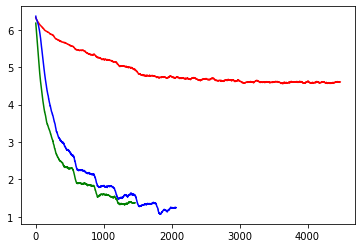

In [16]:
plt.plot(smooth(darknet_losses,50), 'r-')
plt.plot(smooth(resnet_swsl_losses,50), 'b-')
plt.plot(smooth(resnet_losses,50), 'g-')

In [17]:
def predict(net, dataloader, ofname):
    out = open(ofname, 'w')
    out.write("path,class\n")
    net.to(device)
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader, 0):
            if i%100 == 0:
                print(i)
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            fname, _ = dataloader.dataset.samples[i]
            out.write("test/{},{}\n".format(fname.split('/')[-1], data['to_class'][predicted.item()]))
    out.close()

Using the predict function defined above from the tutorials in class, I create CSV files that contain the predictions of the 10000 different bird pictures that can then be submitted to kaggle to test for accuracy.

The resnet model achieved the highest accuracy of 48%.

In [ ]:
predict(resnet, data['test'], "predictions_resnet.csv")
predict(resnet_swsl, data['test'], "predictions_resnet_swsl.csv")
predict(darknet, data['test'], "predictions_darknet.csv")